# 0. Setup

### Import python libraries and local functions. 

In [ ]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from Other.open_abf import *
from Other.ToolBox import IV_style
from scipy.optimize import leastsq
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12,
                    'axes.spines.right': False,
                    'axes.spines.top': False,
                    'axes.linewidth':1.2,
                    'xtick.major.size': 6,
                    'xtick.major.width': 1.2,
                    'ytick.major.size': 6,
                    'ytick.major.width': 1.2,
                    'legend.frameon': False,
                    'legend.handletextpad': 0.1,
                    # 'figure.figsize': [10.0, 3.0],
                    'svg.fonttype': 'none',
                    'text.usetex': False})

### Define your path to your data

In [2]:
pathToData = "data/"
data_folders = glob(pathToData+"*") # The glob function helps you filter your files
data_folders

['data/Fig_Nav', 'data/Fig_Cav', 'data/example_HEKA.dat', 'data/Fig_Kv']

In [3]:
data_files = glob(data_folders[0]+"/*.abf")
data_files

['data/Fig_Nav/NAV_Tho(1)_21309013.abf',
 'data/Fig_Nav/NAV_Cerv(3)_22712021.abf',
 'data/Fig_Nav/NAV_Tho(2)_21309018.abf',
 'data/Fig_Nav/NAV_Cerv(1)_22712019.abf',
 'data/Fig_Nav/NAV_Cerv(2)_22712020.abf',
 'data/Fig_Nav/NAV_Lomb(1)_22919024.abf',
 'data/Fig_Nav/NAV_Lomb(2)_22919023.abf']

In [4]:
# List the protocol for each files
get_protocol_names(data_files)

['K_Steps_VC',
 'Na_IV',
 'K_Steps_VC',
 'Na_IV',
 'Na_Step_-80�+60mV',
 'Ca_Current_VC-IV',
 'Ca_Current_VC-IV']

# 1. IV curve 
#### list the relevant files based on the protocol names:

In [5]:
iv_files = files_from_protocol(protocol_name='Na_IV',files=data_files)
iv_files

['data/Fig_Nav/NAV_Cerv(3)_22712021.abf',
 'data/Fig_Nav/NAV_Cerv(1)_22712019.abf']

#### now let's quickly explore the files

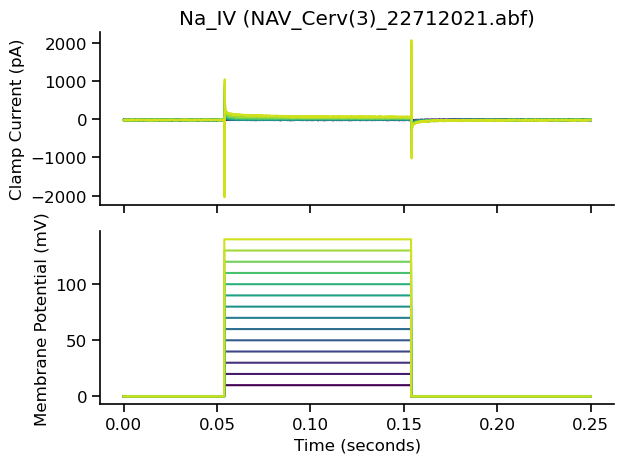

In [6]:
file = iv_files[0]
plot_sweeps(file)

### Select the file you want to analyse and extract raw data: 

In [7]:
file = iv_files[1]

## Extract the sweeps, time and sampling frequency:
sweeps, time, sampling_freq = get_sweeps(file)

print(sweeps.shape)
print(time.shape)
print(f"freq: {sampling_freq} Hz")

(14, 2, 2500)
(2500,)
freq: 10000.0 Hz


### Extract the voltage and current steps from your data. We want to select only the timepoints we want to analyze.
#### From your recording, set the start and end time (in milliseconds):

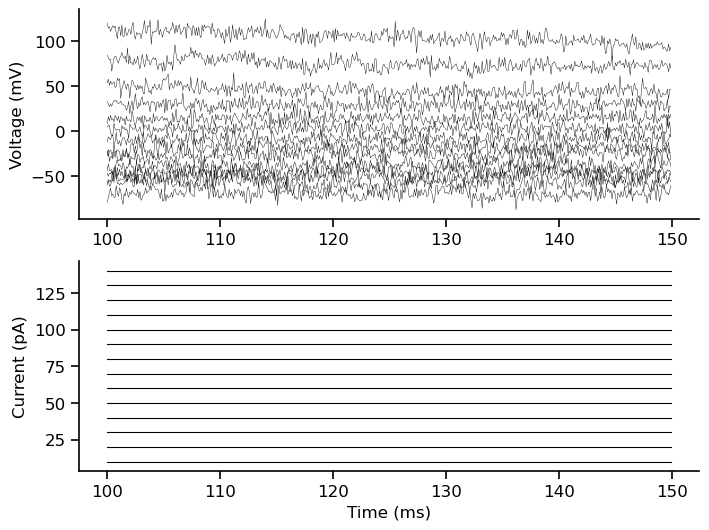

In [8]:
start_time = 100 # milliseconds
end_time = 150 # milliseconds

voltage_traces, v_time = select_sweep_window(sweeps, time, start_time, end_time, sampling_freq, channel=0)
current_traces, i_time = select_sweep_window(sweeps, time, start_time, end_time, sampling_freq, channel=1)

## Plot traces in the chosen window:
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=False)
ax[0].set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, voltage_traces.shape[0])))
ax[0].plot(v_time*1000, voltage_traces.T, color='black', linewidth=0.3)
ax[1].plot(i_time*1000, current_traces.T, color='black', linewidth=0.8)
ax[1].set_xlabel('Time (ms)')
ax[0].set_ylabel('Voltage (mV)')
ax[1].set_ylabel('Current (pA)')
plt.show()

### Now we will calculate the mean for each trace (within the timewindows we selected above):

In [9]:
voltage_traces.shape

(14, 500)

In [10]:
voltage_steps = np.mean(voltage_traces, axis=1) # setting the rigth axis to is crucial: we want to average over time, not over sweeps
voltage_steps

array([-69.1205, -57.5586, -50.5609, ...,  45.8307,  75.1453, 105.0818])

### The Baseline holding current (channel 0):

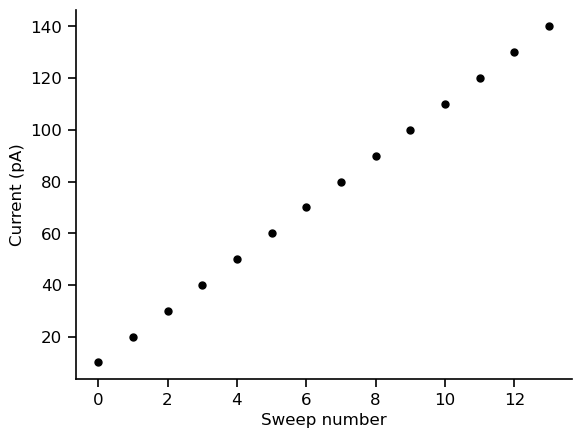

In [27]:
start_time = 137.5
end_time = 152.5
baseline_current_window, t = select_sweep_window(sweeps, time, start_time, end_time, sampling_freq, channel=1)
baseline_current = np.mean(baseline_current_window, axis=1)

fig,ax = plt.subplots()
ax.plot(baseline_current,'o', color='black', markersize=5)
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

###  The peak response in your current (here Na)
#### To choose your window you need to have only the peak you are interested in.
#### Getting rid of the capacitive transient is crucial !

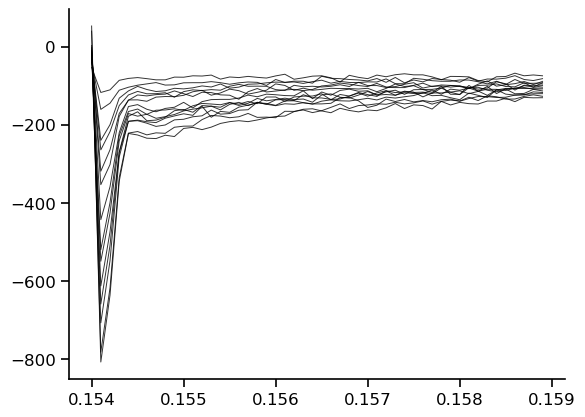

In [28]:
start_time = 154
end_time = 159
peak_window, t = select_sweep_window(sweeps,time,start_time,end_time,sampling_freq,channel=0)
fig, ax = plt.subplots()
for c in peak_window:
    ax.plot(t,c,'k',alpha=0.8, linewidth=0.7)
plt.show()

### Extract the peak (positive or negative)
#### Break down to understand the process : 

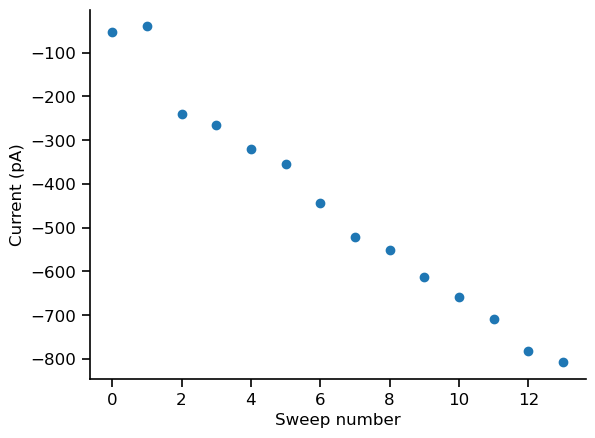

In [29]:
## initialise your list to store the amplitudes
peak_response = []
## loop for each trace
for swp in peak_window:
    ## normalise the trace on the 10 first points:
    base = np.mean(swp[0:10])
    norm = swp - base
    ## take the absolute trace:
    abs_trace =  abs(norm)
    ## get the position of the max response:
    i_peak = np.argmax(abs_trace)
    ## from the original swp get the 
    ## value at the absolute max position:
    peak = swp[i_peak]
    ## append to the storage list
    peak_response.append(peak)

fig,ax = plt.subplots()
ax.plot(peak_response,'o')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

### Fortunatly you can write this in one line with our beloved list comprehension,
### and to be even classier we can define a function

In [30]:
def peak(peak_window):
    return np.array([s[np.argmax(np.abs(s - np.mean(s[0:10])))] 
                     for s in peak_window])

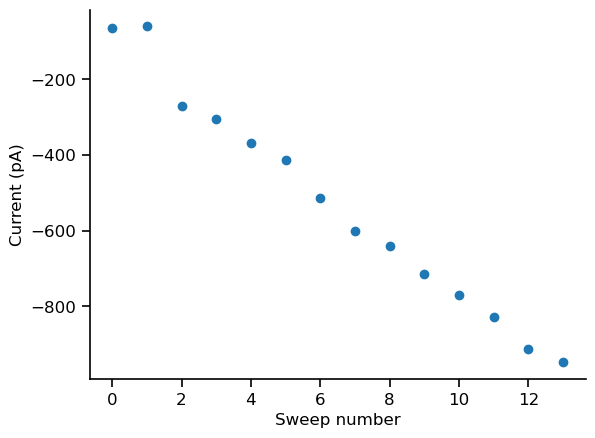

In [31]:
peak_response = peak(peak_window)
## and normalise over the baseline current:
peak_response -= baseline_current
fig,ax = plt.subplots()
ax.plot(peak_response,'o')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

### Lets put all this into a nice looking plot:

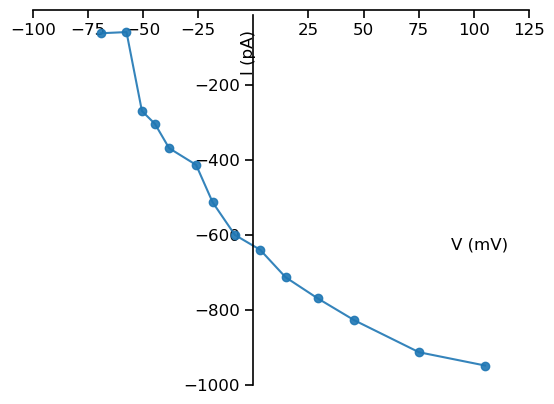

In [33]:
fig,ax = plt.subplots()
ax.plot(voltage_steps,peak_response,'-o',alpha=0.9)
ax.set_xlabel('V (mV)')
ax.set_ylabel('I (pA)')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_label_coords(0.9, 0.4) 
ax.yaxis.set_label_coords(0.45, 0.9)
# Customize ticks to remove the 0 ticks and labels
xticks = [tick for tick in ax.get_xticks() if tick != 0]
yticks = [tick for tick in ax.get_yticks() if tick != 0]
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.show()

In [34]:
## create a function to add the style to a existing ax
def IV_style(ax,
            xcoord=(0.9, 0.4),
            ycoord=(0.45, 0.9)):
    '''
    ax from fig,ax = plt.subplots()
    xcoord and ycoord are coordinate for the axis labels
    '''
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_xlabel('V (mV)')
    ax.set_ylabel('I (pA)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_label_coords(xcoord[0], xcoord[1]) 
    ax.yaxis.set_label_coords(ycoord[0], ycoord[1])
    # Customize ticks to remove the 0 ticks and labels
    xticks = [tick for tick in ax.get_xticks() if tick != 0]
    yticks = [tick for tick in ax.get_yticks() if tick != 0]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

### Now lets put all this into a function !

In [36]:
def IV(f, voltage_steps, vtimes, btimes, ptimes, plot=True,
       xcoord=(0.9, 0.4), ycoord=(0.45, 0.9)):
    '''
    Takes a filename : f
    ALL TIMES IN SECONDS
    voltage step window (vtimes): (v_start,v_end)
    baseline current window (btimes): (i_start,i_end)
    peak current window (ptimes): (i_start,i_end)
    plot : boolean to show or not the plot
    xcoord and ycoord are coordinate for the axis labels
    
    returns the peak amplitudes and voltage steps values.
    '''
    # Extract the sweeps,time and sampling rate:
    swps, swp_time, sr = get_sweeps(f)
    # Extract the start and end window times:
    v_start,v_end = vtimes
    b_start,b_end = btimes
    p_start,p_end = ptimes
    # extract the voltage steps:
    voltage_trace,t = np.mean(select_sweep_window(swps,swp_time,v_start,v_end,sr,channel=1),axis=1)
    # extract baseline current:
    baseline_current,t = np.mean(select_sweep_window(swps,swp_time,b_start,b_end,sr,channel=0),axis=1)
    # extract peak current:
    peak_window,t = select_sweep_window(swps,swp_time,p_start,p_end,sr,channel=0)
    peak_response = peak(peak_window)
    # and normalise over the baseline current:
    peak_response -= baseline_current
    # plot the result:
    if plot==True:
        fig,ax = plt.subplots()
        ax.plot(voltage_steps,peak_response,'-o',alpha=0.9)
        IV_style(ax,xcoord=xcoord,ycoord=ycoord)
        plt.show()
    
    return voltage_steps,peak_response

In [ ]:
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
v,i = IV(file,voltage_steps, vtimes, btimes, ptimes)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Lets loop that around all the IV files:

In [ ]:
plt.close('all')
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
for f in iv_files:
    plot_swps(f)
    try:
        v,i = IV(f,vtimes,btimes,ptimes)
    except:
        print(f)
        print('Error computing the IV curve ')
    plt.show()

### Finally take all the IV curves into one plots 

In [1]:
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
iv = []
fig,ax = plt.subplots()
for j,f in enumerate(iv_files[:-2]):
    v,i = IV(f,vtimes,btimes,ptimes,plot=False)
    ax.plot(v,i,'-o',alpha=0.7,label=f'Cell {j+1}')
    iv.append((i,v))
IV_style(ax)
ax.legend()
plt.show()

NameError: name 'plt' is not defined

# All the function are in the ToolBox.py files and can be imported in your own notebooks

In [ ]:
from Other.ToolBox import * ## import all the function 
from Other.ToolBox import IV ## only imports the IV function
import Other.ToolBox as TB ## you call any function by calling TB.function (example TB.IV())